# Problem Statement:

# Use KNN and Decision Trees to build a classifier for predicting labels as Magnitude(Mw).

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_roc_curve
import warnings;warnings.filterwarnings('ignore')

# Reading dataset

For magnitude, we keep column Mw only as rest of columns are all derived magnitude columns which are derived from Mw.

In [ ]:
df = pd.read_csv('/content/Indian Earthquakes List Update_Magnitudes.csv', encoding='latin1', skiprows=10)
df.columns=['S.No','Year', 'Month','Date','UTC','IST','magnitude2','magnitude','magnitude3','magnitude4','ms','ml','LAT(N)','LONG(E)','Depth(km)','MM','MMI','MME','Location','Reference' ]
df = df.drop(columns=['MM', 'MMI','MME','magnitude2','magnitude3','magnitude4','ms','ml','IST'])
df.head()

,S.No,Year,Month,Date,UTC,magnitude,LAT(N),LONG(E),Depth(km),Location,Reference
0,1,-2474,0,0.0,NaN,7.5,71,24,0.0,NaN,Dr STGR
1,2,-325,0,0.0,NaN,7.5,71,24,0.0,NaN,Dr STGR
2,3,25,0,0.0,NaN,7.5,72.9,33.72,0.0,NaN,Dr STGR
3,4,26,5,10.0,08.19.10.0,6.1397,17.3,80.1,NaN,NaN,NEIC
4,5,26,5,10.0,08.19.10.0,6.1397,26,97,80.0,Myanmar,G-R


# Analysing dataset

Cols with null values: Month, Date, UTC, magnitude, Depth, Location, Reference

In [ ]:
print(df.isnull().sum())

S.No             0
Year             0
Month           18
Date            57
UTC          31803
magnitude     2504
LAT(N)           0
LONG(E)          0
Depth(km)     2178
Location     43615
Reference     1582
dtype: int64


# Feature Selection

We are dropping following cols:

* S.No : It only contains order and hence not used in prediction

* UTC: Around 60% values in this column are NULL values so dropping whole column altogether

* Location: Around 80% values in this column are NULL values so dropping whole column 

Handling NULL values:

* Depth: It contains a few(~2%) NULL values, so replacing NULL with mean value of depth column

* Magnitude: Since magnitude contains class lables, so we drop all those rows for which magnitude is NULL

* Since rest of the columns contain only a few NULL values so we handle them by dropping the row altogether.

In [ ]:
df2 = df[['Year','Month','Date','LAT(N)','LONG(E)','Depth(km)','magnitude','Reference']]
df2 = df2[df.Month != " "]
df2[['Depth(km)']] = df2[['Depth(km)']].fillna(df2[['Depth(km)']].mean())
df2 = df2.dropna(axis=0,how='any') 
df2 = df2.reset_index(drop=True)
for i in range(len(df2['magnitude'])):
    try:
        df2['magnitude'][i] = float(df2['magnitude'][i])
    except:
        df2['magnitude'][i]=np.nan
df2 = df2.dropna(axis=0,how='any')
df2=df2.astype({'Month':float,'magnitude':float})

# Handling Categorical values

'Reference"  column contains categorical values, so we do label encoding for this column

# Processing DateTime

There are 3 separate columns for year, month and date; we combine these 3 columns in 'DateTime' column which if of python DateTime format

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df2['Reference']=encoder.fit_transform(df2['Reference'])

df2['DateTime'] = pd.to_datetime(df2['Year']*10000 + df2['Month']*100 + df2['Date'], format='%Y%m%d', errors='ignore')
df2=df2.drop(columns=['Year','Month','Date'])

# Data Cleaning

* Latitude and Longitide values contain values in these formats: '31.8°N', '10.6 N', '10.6N', '02.5°N', '12.3ｰN', '18.1?', '18.1S'

* So we clean these values into uniform float values

* Moreover latitude can range from -90 to 90 for and longitude can range from -180 to 180, so any values outside these range are handled appropriately

In [ ]:
def cleanLat(x):
    x=str(x)
    x=x.replace(',','.')
    x=x.replace('°','')
    x=x.replace('?','')
    x=x.replace('-','')
    if('N' in x): 
        if(float(x.split('N')[0]))>90:
            return 90-float(x.split('N')[0])
        return float(x.split('N')[0])
    if('S' in x):  return 0 - float(x.split('S')[0])
    if float(x)>90:
        return 90-float(x)
    return float(x)
def cleanLong(x):
    x=str(x)
    x=x.replace(',','.')
    x=x.replace('°','')
    x=x.replace('?','')
    x=x.replace('-','')
    x=x.replace('S','')
    if('E' in x): 
        return float(x.split('E')[0])
    if('W' in x):   return 0 - float(x.split('W')[0])
    return float(x)

df2['LAT(N)'] = df2['LAT(N)'].apply(cleanLat)
df2['LONG(E)'] = df2['LONG(E)'].apply(cleanLong)

# Threshold selection for magnitude

Selecting '4.5'  as threshold value for split as 50 percentile lies at 4.5 which means around half the values fall in class 0(no earthquake) and other half falls in class 1(earthquake)

In [ ]:
print(df2['magnitude'].describe())
def cat(x):
    if float(x)<4.5:
        return 0
    else:
        return 1
df2['magnitude'] = df2['magnitude'].apply(cat)
print(df2['magnitude'].value_counts())

count    48887.000000
mean         4.595739
std          0.604188
min          1.682800
25%          4.200000
50%          4.500000
75%          4.884400
max          9.100000
Name: magnitude, dtype: float64
1    25298
0    23589
Name: magnitude, dtype: int64


In [ ]:
x=df2[['LAT(N)','LONG(E)','Depth(km)','Reference']]
y=df2[['magnitude']]
print(x.head())
print(y.head())

   LAT(N)  LONG(E)  Depth(km)  Reference
0    71.0    24.00   0.000000          8
1    71.0    24.00   0.000000          8
2    72.9    33.72   0.000000          8
3    17.3    80.10  45.570115         26
4    26.0    97.00  80.000000          9
   magnitude
0          1
1          1
2          1
3          1
4          1


# Train Test split

80% for training and 20% for testing

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42)

# Q1) Plot ROC for both these classifiers for K as parameter in KNN and pre-prune depth as a parameter in Decision Tree.

# KNN classifier

Testing for differenet k values and plotting roc curves

For k =  3  ROC AUC score =  0.6175202358558576 , Accuracy: 0.5915320106361219 , F1 score:  0.610189342182315
For k =  5  ROC AUC score =  0.637902851964739 , Accuracy: 0.6001227244835344 , F1 score:  0.6181640625
For k =  7  ROC AUC score =  0.6478439047657368 , Accuracy: 0.6027817549601145 , F1 score:  0.6209252391177045
For k =  11  ROC AUC score =  0.6584710821740049 , Accuracy: 0.6082020863162201 , F1 score:  0.6239324629429666
For k =  17  ROC AUC score =  0.6665391447291211 , Accuracy: 0.6203722642667212 , F1 score:  0.6375000000000001
For k =  27  ROC AUC score =  0.6741455506265236 , Accuracy: 0.6212926978932297 , F1 score:  0.6401710232241765


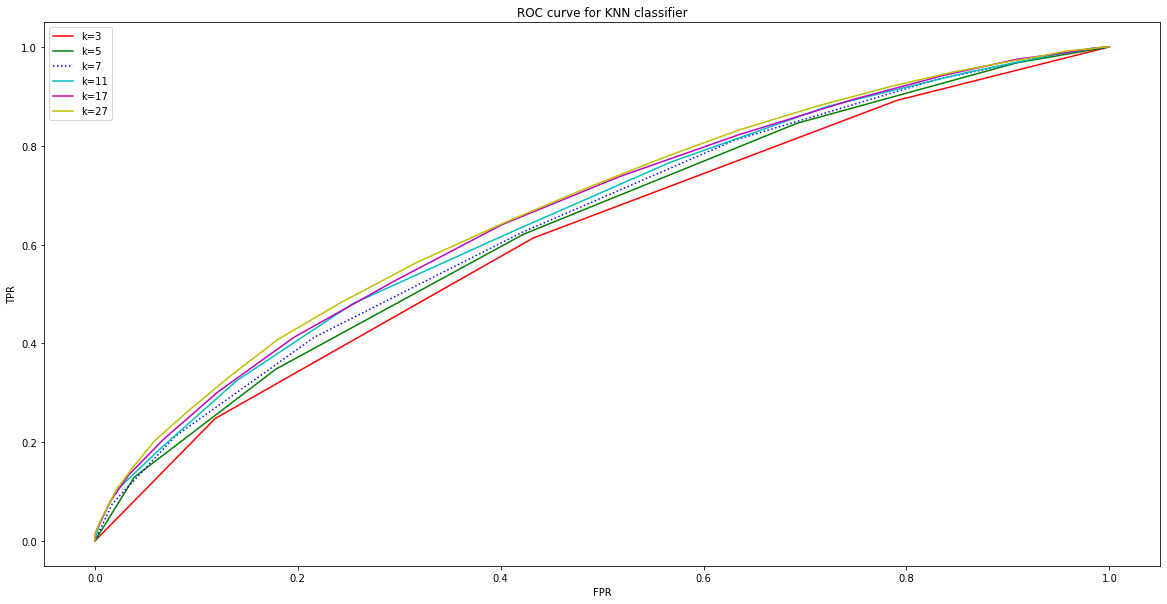

In [ ]:
k_values=[3,5,7,11,17,27]
legend=['r','g-','b:','c','m','y']
label=['k=3','k=5','k=7','k=11','k=17','k=27']
plt.figure(figsize=(20,10))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve for KNN classifier")
for i in range(len(k_values)):
    model = KNeighborsClassifier(n_neighbors=k_values[i])
    model.fit(x_train,y_train)
    predicted= model.predict(x_test)
    proba= model.predict_proba(x_test)[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test,proba, pos_label=1)
    print("For k = ",k_values[i]," ROC AUC score = ",metrics.roc_auc_score(y_test,proba), end=" ")
    print(", Accuracy:" ,metrics.accuracy_score(y_test,predicted), end=" ")
    print(", F1 score: ",metrics.f1_score(y_test,predicted))
    plt.plot(fpr,tpr,legend[i],label=label[i])

plt.legend()
plt.show()

# Decision Tree classifier

Testing for differenet values of tree depth and plotting roc curves

For tree_depth =  3  ROC AUC score =  0.6402033183785831 , Accuracy: 0.6075884638985478 , F1 score:  0.6703891418263036
For tree_depth =  5  ROC AUC score =  0.6499135742858773 , Accuracy: 0.6141337696870526 , F1 score:  0.6506804925469865
For tree_depth =  7  ROC AUC score =  0.6618241232526245 , Accuracy: 0.6193495602372673 , F1 score:  0.6631674208144797
For tree_depth =  9  ROC AUC score =  0.6713374064908981 , Accuracy: 0.6201677234608305 , F1 score:  0.6492255383452966
For tree_depth =  11  ROC AUC score =  0.6643327322932069 , Accuracy: 0.6178155041930865 , F1 score:  0.6393205289064762
For tree_depth =  13  ROC AUC score =  0.6533370091505636 , Accuracy: 0.6181223154019226 , F1 score:  0.6439061605950791


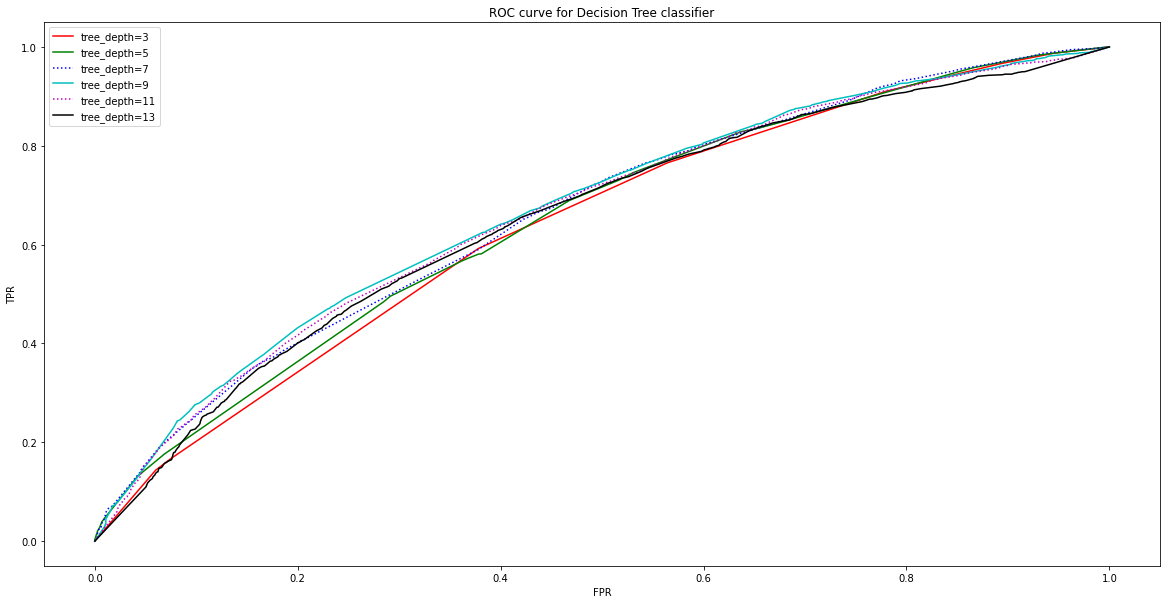

In [ ]:
depth_values=[3,5,7,9,11,13]
legend=['r','g-','b:','c-','m:','k-']
label=['tree_depth=3','tree_depth=5','tree_depth=7','tree_depth=9','tree_depth=11','tree_depth=13']

plt.figure(figsize=(20,10))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve for Decision Tree classifier")
for i in range(len(depth_values)):
    model = DecisionTreeClassifier(max_depth=depth_values[i])
    model.fit(x_train,y_train)
    predicted= model.predict(x_test)
    proba= model.predict_proba(x_test)[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test,proba, pos_label=1)
    print("For tree_depth = ",depth_values[i]," ROC AUC score = ",metrics.roc_auc_score(y_test,proba), end=" ")
    print(", Accuracy:" ,metrics.accuracy_score(y_test,predicted), end=" ")
    print(", F1 score: ",metrics.f1_score(y_test,predicted))
    plt.plot(fpr,tpr,legend[i],label=label[i])
plt.legend()
plt.show()             

# Q2) Which is the better classifier for this data amongst the two? Give Reasoning.

Ans) Decision Tree classifier is better among the two because AOC(Area Under Curve) score for decision tree classifier is higher comparatively.

# Q3) What could be the best possible values of the parameters for respective classifier based on the ROC curves? Give Reasoning.

Ans) Considering ROC AUC score for different parameters, we found that:

Best possible value of k for KNN classifier = 17

Best possible value of tree depth for Decision Tree classifier = 9

# Q4) If you have to choose only a subset of two features to predict earthquake, which ones would it be? Give Reasoning. 

Ans) Subset of 2 features we would use:

1) Latitude
2) Depth

Reasoning: Split at level 1 of decision tree(as shown below) is made for latitude attribute. At level 2, split is made on depth attribute. Hence these 2 are the most important attributes for classification.

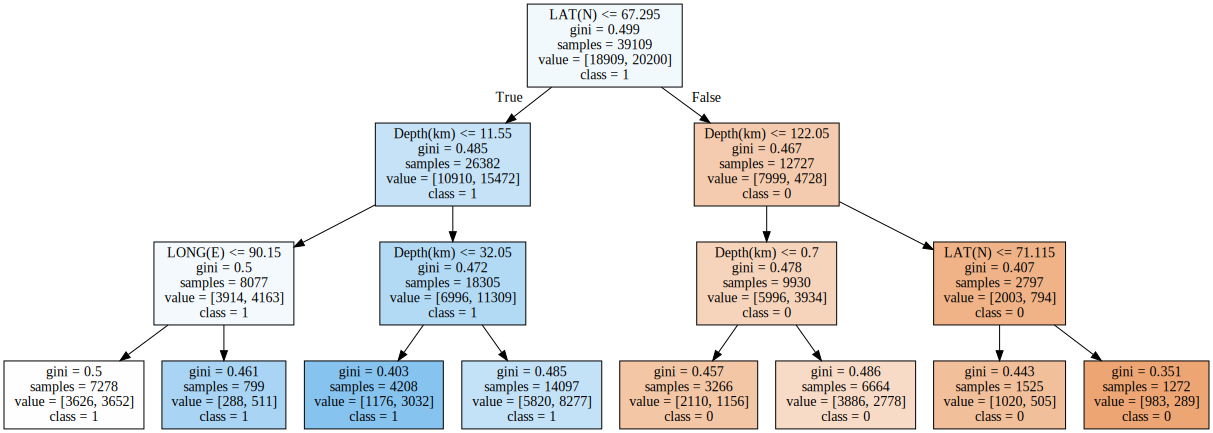

In [ ]:
import graphviz
from sklearn import tree
import pydotplus

model = DecisionTreeClassifier(max_depth=3)
model.fit(x_train,y_train)
dot_data = tree.export_graphviz(model, out_file=None, feature_names=x.columns,  class_names=["0","1"], filled=True)
graph = graphviz.Source(dot_data) 
graph   

# Q5) Consider test results of the best model from above analysis. Report the input features that was used to achieve this. Report the new set of features that was used and also report the improvements in test results that was achieved. Please use appropriate metrics to report the results.

Ans) Improvisation: Instead of using 3 features(Year, Month, Date), we combined them into a single column having DateTime type. Following improvements were noticed for Decision Tree classifier(at depth=9):

AUC score before improvisation: 0.762

AUC score after improvisation: 0.773